## Numpy实现卷积神经网络

### Zero-Padding

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cnn_utils

In [2]:
def zero_pad(X, pad):
    """
    任务：
    对数据集 X 中的所有图像进行零填充（padding）。填充应用于图像的高度和宽度
    参数：

    X —— 一个形状为 (m, n_H, n_W, n_C) 的 Python NumPy 数组，表示一批 m 张图像。

    pad —— 整数，表示在图像的垂直和水平方向上填充的宽度。

    返回值：

    X_pad —— 填充后的图像数组，形状为 (m, n_H + 2 * pad, n_W + 2 * pad, n_C)。
    """
    X_pad = np.pad(X, ((0, ), (pad, ), (pad, ), (0, )), mode="constant", constant_values=0)
    return X_pad

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 9, 9, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 9, 9, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
All tests passed!


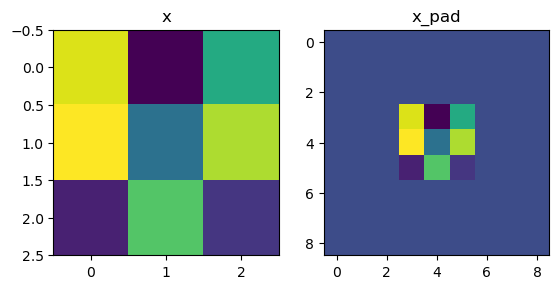

In [3]:
# 运行 + 测试 zero_pad
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 3)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[1,1] =\n", x[1, 1])
print ("x_pad[1,1] =\n", x_pad[1, 1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0, :, :, 0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0, :, :, 0])
cnn_utils.zero_pad_test(zero_pad)

### 单步卷积
1.对于黑白的图像（颜色通道数为1）来说，单步卷积如下图：
<img src="./images/slice_convolution_example.png">

2.对于彩色的图像（颜色通道数为3）来说，单步卷积如下图：
<img src="./images/rgb_convolution.jpg">

In [4]:
def conv_single_step(a_slice_prev, W, b):
    """
    **功能说明：**
    对前一层输出激活值中的一个切片（`a_slice_prev`）应用由参数 `W` 定义的一个卷积核（filter）。
    切片：卷积窗口当前所对应的输入，这里只需要实现卷积的一步操作，不需要滑动卷积窗口

    **参数：**

    * `a_slice_prev` —— 输入数据的一个切片，形状为 `(f, f, n_C_prev)`
    * `W` —— 卷积核的权重参数，窗口矩阵，形状为 `(f, f, n_C_prev)`
    * `b` —— 卷积核的偏置参数，窗口矩阵，形状为 `(1, 1, 1)`

    **返回值：**

    * `Z` —— 一个标量值，表示将卷积核 `(W, b)` 与输入数据的一个切片 `x` 进行卷积的结果。
    """
    Z = np.sum(W * a_slice_prev) + np.sum(b)
    return Z

In [5]:
# 运行 + 测试conv_single_step
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)
cnn_utils.conv_single_step_test(conv_single_step)

assert (type(Z) == np.float64), "You must cast the output to numpy float 64"
assert np.isclose(Z, -6.999089450680221), "Wrong value"

Z = -6.999089450680221
All tests passed!


### 完整卷积

<center>
<table>
<tr>
<th style="font-size: 20px">pad=1, stride=2</th>
<th style="font-size: 20px">pad=0, stride=1</th>
<th style="font-size: 20px">same padding, stride=1</th>
</tr>
<tr>
<th><img src="./images/padding-stride-2.webp" width="400" height="400"></th>
<th><img src="./images/no_padding_no_strides.webp" width="400" height="400"></th>
<th><img src="./images/same_padding_no_strides.gif" width="400" height="400"></th>
</tr>
</table>
</center>



在卷积神经网络中，卷积操作通常会使输入图像的尺寸缩小。对于输入大小为 $n \times n$ 的图像，卷积核大小为 $f \times f$，填充宽度为 $p$，步幅为 $s$，则经过卷积核之后，输出大小为：

$$
output_{size} = \lfloor \frac{n + 2p - f}{s} \rfloor + 1
$$

其中：$\lfloor \cdot \rfloor$ 代表向下取整

例如

* 输入 $7 \times 7$，卷积核 $3 \times 3$，无填充 ($p=0$)：

  * 当 $s=1$ → 输出大小：$(7 - 3)/1 + 1 = 5$，即 $5 \times 5$。
  * 当 $s=2$ → 输出大小：$\lfloor (7 - 3)/2 \rfloor + 1 = 3$，即 $3 \times 3$。

下面的代码是默认一个卷积核的情况，图片用来启发代码思路
<img src="./images/convolution-one-filter-example.png">

<img src="./images/RGB_Convolutions.png">

In [6]:
def conv_forward(A_prev, W, b, hparameters):
    """
    实现卷积函数的前向传播

    参数：
    A_prev -- 前一层的输出激活值，
              形状为 (m, n_H_prev, n_W_prev, n_C_prev) 的 numpy 数组
    W -- 卷积核的权重，
         形状为 (f, f, n_C_prev, n_C) 的 numpy 数组
    b -- 偏置，
         形状为 (1, 1, 1, n_C) 的 numpy 数组
    hparameters -- 包含超参数的 python 字典，键包括 "stride"和 "pad"， stride键对应的是步长，pad键对应的是填充

    返回值：
    Z -- 卷积后的输出，
         形状为 (m, n_H, n_W, n_C) 的 numpy 数组
    """
    stride = hparameters["stride"]
    pad = hparameters["pad"]

    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape         # m 为样本数量
    f, n_C = W.shape[0], W.shape[-1]                        # n_C 为通道数量

    # 计算 图像卷积后的输入高度与宽度
    n_H = int((n_H_prev + 2 * pad - f) / stride) + 1
    n_W = int((n_W_prev + 2 * pad - f) / stride) + 1

    # 初始化 输出 Z
    Z = np.zeros((m, n_H, n_W, n_C))

    # 对上一层的输入用0填充 --》 之后我们对填充后的数组进行操作
    A_prev_pad = zero_pad(A_prev, pad)

    # 对输出的 Z 进行填充
    for h_idx in range(n_H):
        for w_idx in range(n_W):
            # 指定切片区域位置
            horizen_start = h_idx * stride
            horizen_end = horizen_start + f
            vertical_start = w_idx * stride
            vertical_end = vertical_start + f

            # 取单个切片 --> m x f x f x n_C_prev
            a_slice_prev = A_prev_pad[:,  horizen_start:horizen_end, vertical_start:vertical_end, :]
            # W[np.newaxis, ...] :                  1 x f x f x n_C_prev x n_C
            # a_slice_prev[..., np.newaxis] :       m x f x f x n_C_prev x 1
            # W * a_slice_prev:                     m x f x f x n_C_prev x n_C  --> np.sum(..., axis=(1, 2, 3)) -->  m x n_C
            # b :                                   1 x 1 x 1 x n_C
            # 对于每个切片，计算 W * x + b
            Z[:, h_idx, w_idx, :] = np.sum(a_slice_prev[..., np.newaxis] * W[np.newaxis, ...],
                                           axis=(1, 2, 3)) + b[0, 0, 0, :]

    return Z


In [7]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 7, 4)
W = np.random.randn(3, 3, 4, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 1,
               "stride": 2}

Z = conv_forward(A_prev, W, b, hparameters)
z_mean = np.mean(Z)
z_0_2_1 = Z[0, 2, 1]
print("Z's mean =\n", z_mean)
print("Z[0,2,1] =\n", z_0_2_1)

cnn_utils.conv_forward_test_1(z_mean, z_0_2_1)
cnn_utils.conv_forward_test_2(conv_forward)

Z's mean =
 0.5511276474566766
Z[0,2,1] =
 [-2.17796037  8.07171329 -0.5772704   3.36286738  4.48113645 -2.89198428
 10.99288867  3.03171932]
First Test: All tests passed!
Second Test: All tests passed!


### 池化层（Pooling Layer）
池化层是卷积神经网络中的关键组成部分，主要用于降低特征图的尺寸、减少参数量、控制过拟合，并提升模型的平移不变性等等

池化层的主要作用有
- **降维** ： 减少数据量，降低计算成本
- **特征不变性**：使模型对小的平移、旋转、缩放不敏感
- **防止过拟合**：减少参数，增强模型的泛化能力
- **保留主要特征**：通过取区域内的最大值或平均值，保留主要特征信息

常见的池化方式有三种：最大池化（Max Pooling）、平均池化（Average Pooling）和全局平均池化（Global Average Pooling）

1️⃣最大池化：

取区域内的最大值，其特点为保留纹理强烈的特征，公式表示如下：
$$
Y_{i, j} = \max (X_{i:i+f , \; j: j+f })
$$
其中，$f$ 为卷积核的大小，$i, j$ 分别代表图像切片的起始的高度和宽度下标

2️⃣平均池化：

取区域内的平均值，其作用为平滑特征图，公式表示如下：
$$
Y_{i, j} = \frac{1}{f^2} \sum X_{i:i+f , \;  j: j+f }
$$
其中，$f$ 为卷积核的大小，$i, j$ 分别代表图像切片的起始的高度和宽度下标

3️⃣全局平均池化

对整个特征图取平均，常用于替代全连接层，减少参数量，公式如下：
$$
Y_c = \frac{1}{H \times W} \sum_i^H \sum_j^W X_{i, j, c}
$$
其中，$c$ 为通道数

池化层的输入图像和输出图像的尺寸大小对应为：
$$
\begin{aligned}
H_{out} &= \left\lfloor \frac{H_{in} - f + 2p}{s} \right\rfloor + 1 \\
W_{out} &= \left\lfloor \frac{W_{in} - f + 2p}{s} \right\rfloor + 1 \\
C_{out} &= C
\end{aligned}
$$
其中，$f$ 为卷积核的大小，$p$ 为填充的长度，$s$ 为步幅


以下两幅图用于启发思路

<img src="./images/max-pooling-example.webp" style="zoom: 70%;">

<img src="./images/convolution-block-detail.webp">

In [8]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    实现池化层的前向传播

    参数：
    A_prev -- 输入数据，形状为 (m, n_H_prev, n_W_prev, n_C_prev) 的 numpy 数组
    hparameters -- 包含超参数的 python 字典，键包括 "f"（池化窗口大小）和 "stride"（步幅）
    mode -- 要使用的池化方式，字符串类型，可选 "max" 或 "average"

    返回值：
    A -- 池化层的输出，形状为 (m, n_H, n_W, n_C) 的 numpy 数组
    """

    # TODO: 实现
    f = hparameters["f"]
    stride = hparameters["stride"]

    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape

    n_H = int((n_H_prev - f) / stride) + 1
    n_W = int((n_W_prev - f) / stride) + 1
    n_C = n_C_prev

    # 初始化输出
    A = np.zeros((m, n_H, n_W, n_C))

    for h in range(n_H):
        for w in range(n_W):
            vertical_start = h * stride
            vertical_end = vertical_start + f
            horizen_start = w * stride
            horizen_end = horizen_start + f

            a_slice_prev = A_prev[:, vertical_start:vertical_end, horizen_start:horizen_end, :]

            # a_slice_prev : m, f, f, n_C_prev --> m x n_C_prev
            # A[:, h, w, :]:                       m x n_C  (n_C_prev)
            if mode == "max":
                A[:, h, w, :] = np.max(a_slice_prev, axis=(1, 2))
            else:
                A[:, h, w, :] = np.mean(a_slice_prev, axis=(1, 2))

    return A


In [9]:
# Case 1: 步幅为1
print("CASE 1:\n")
np.random.seed(1)
A_prev_case_1 = np.random.randn(2, 5, 5, 3)
hparameters_case_1 = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev_case_1, hparameters_case_1, mode = "max")
print("mode = max")
print("A.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])
A, cache = pool_forward(A_prev_case_1, hparameters_case_1, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])

cnn_utils.pool_forward_test_1(pool_forward)

# Case 2: 步幅为2
print("\n\033[0mCASE 2:\n")
np.random.seed(1)
A_prev_case_2 = np.random.randn(2, 5, 5, 3)
hparameters_case_2 = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev_case_2, hparameters_case_2, mode = "max")
print("mode = max")
print("A.shape = " + str(A.shape))
print("A[0] =\n", A[0])
print()

A, cache = pool_forward(A_prev_case_2, hparameters_case_2, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A[1] =\n", A[1])

cnn_utils.pool_forward_test_2(pool_forward)

CASE 1:

mode = max
A.shape = (3, 3, 3)
A[1, 1] =
 [1.14472371 0.90159072 1.65980218]
mode = average
A.shape = (3, 3, 3)
A[1, 1] =
 [0.04737072 0.02592447 0.09203384]
All tests passed!

CASE 2:

mode = max
A.shape = (2, 2, 3)
A[0] =
 [[1.74481176 0.90159072 1.65980218]
 [1.74481176 1.6924546  1.65980218]]

mode = average
A.shape = (2, 2, 3)
A[1] =
 [[-0.38268052  0.23257995  0.6259979 ]
 [-0.09525515  0.268511    0.46605637]]
All tests passed!
